In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append('../../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

# EDA On Outlier Set

In [5]:
metrics=['roc_auc', 'accuracy', 'precision']

## Load Data

In [6]:
ip_address = '18.218.116.177'
outlier_data, _ = fetch_model_data.fetch_model_data(ip_address, split=True)

In [7]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
    'first_word_approp',
]

In [8]:
X, y = outlier_data[first_feature_set], outlier_data.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# Basic Eda

<BarContainer object of 2 artists>

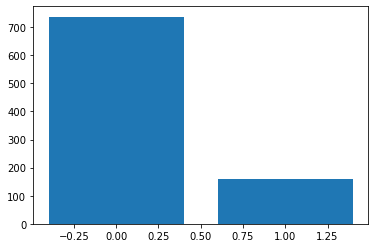

In [10]:
plt.bar([0, 1], outlier_data.third_reading.value_counts())

In [15]:
outlier_data.third_reading.value_counts()[1] / outlier_data.shape[0]
# 18% of the data is class 1 (gets a third reading)

0.17653631284916202

In [19]:
by_author = outlier_data.groupby('author_id').third_reading.agg(['sum', 'count']).reset_index()
by_author['perc_third'] = by_author['sum'] / by_author['count']

In [20]:
by_author
# Big difference between authors
    # However, I imagine if I use lots of author data, it's gonna make decision on a single pt
    # How well could I do with just non-author features?

,author_id,sum,count,perc_third
0,1052,21,152,0.138158
1,1055,11,231,0.047619
2,1082,126,512,0.246094


# Non-Author Features

In [21]:
non_author_features = [
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
    'first_word_approp',
]

In [56]:
def print_histograms(data, features):
    fig, ax = plt.subplots(nrows=len(features))

    fig.set_figheight(6*len(features))
    for a, col in zip(ax, features):
        a.hist(data[data.third_reading == 0][col], alpha=0.4, bins=50, log=True)
        a.hist(data[data.third_reading == 1][col], alpha=0.4, bins=50, log=True)
        a.set_title(col)


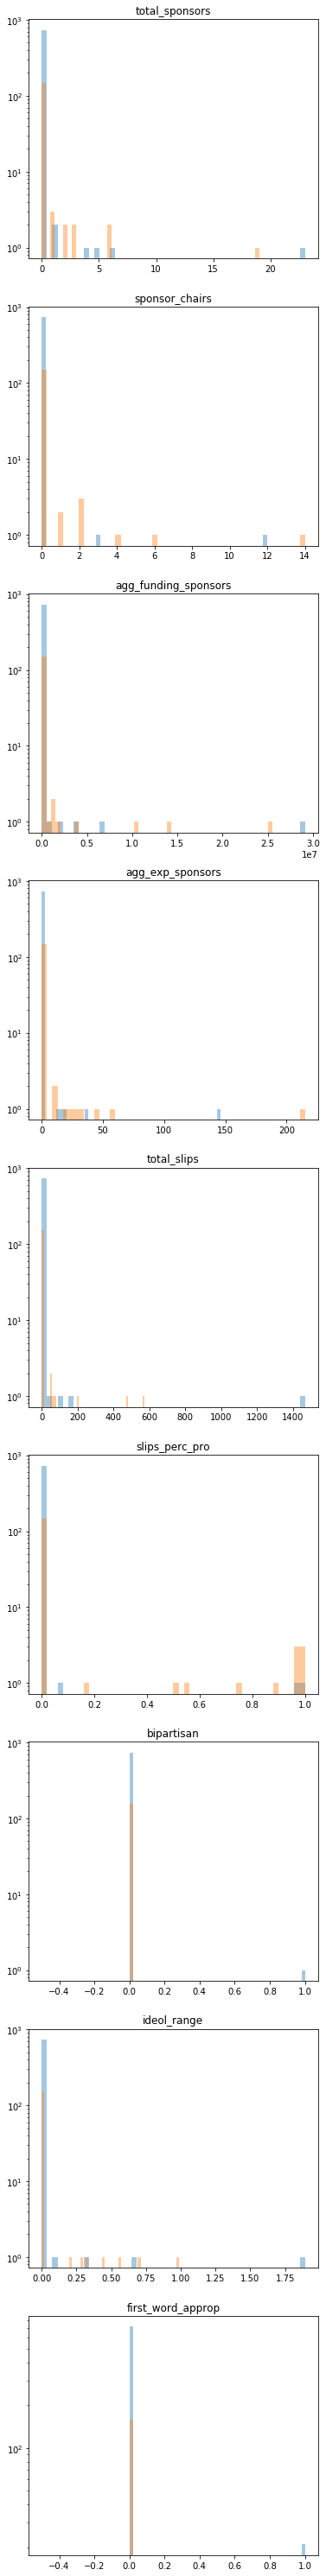

In [57]:
print_histograms(outlier_data, non_author_features)

In [ ]:
# good features:
    # slips_perc_pro -> might try binary
    # one of total_sponsors, agg_exp_sponsors, sponsor_chairs
# bad features:
    # ideol_range
    # bipartisan
    # total slips
    # agg_funding_sponsors

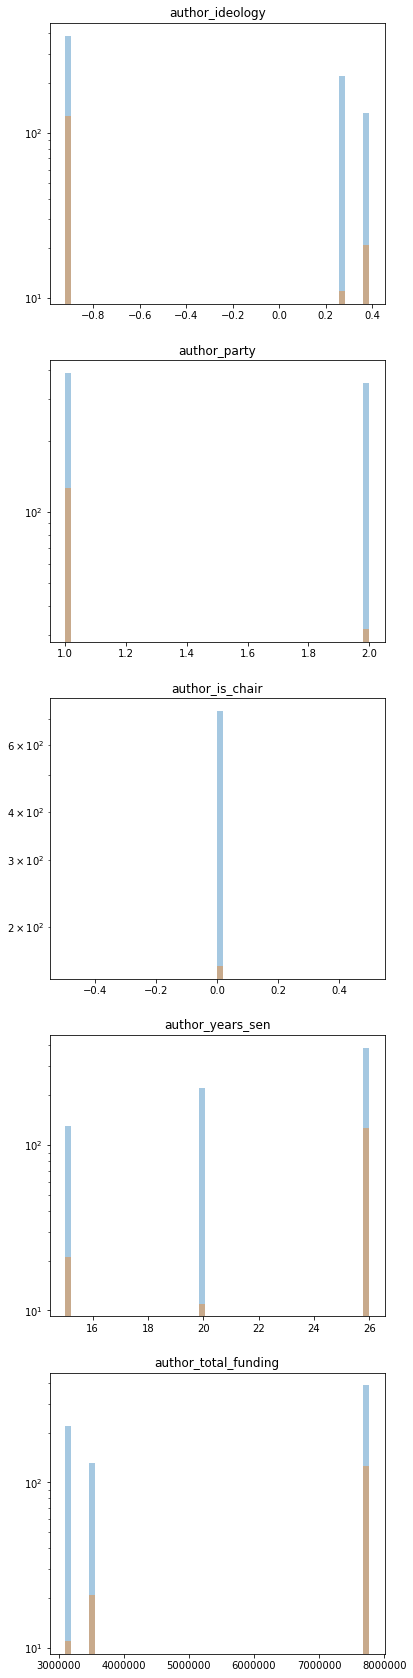

In [58]:
author_features = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
]
print_histograms(outlier_data, author_features)

In [ ]:
# good features:
    # author_party
# almost:
    # author_total_funding (actually no, one dem has more money -> not a real rel probably)
# bad features:
    # everything else

In [59]:
outlier_data.groupby(['author_total_funding', 'author_party']).agg('mean')

,,bill_id,author_id,author_ideology,author_is_chair,author_years_sen,total_sponsors,dem_sponsors,rep_sponsors,most_liberal_sponsor_ideology,most_cons_sponsor_ideology,...,agg_funding_sponsors,agg_exp_sponsors,total_slips,pro_slips,opp_slips,no_pos_slips,slips_perc_pro,bipartisan,ideol_range,first_word_approp
author_total_funding,author_party,,,,,,,,,,,,,,,,,,,,,
3097623.20,2,9.490708e+05,1055.0,0.266,0.0,20.0,0.034632,0.004329,0.030303,-0.000823,-0.000416,...,37117.592771,0.207792,7.155844,0.069264,7.047619,0.038961,0.000332,0.000000,0.000407,0.000000
3478061.43,2,1.086415e+06,1052.0,0.387,0.0,15.0,0.203947,0.092105,0.111842,-0.000961,0.013717,...,220200.195789,1.157895,0.013158,0.013158,0.000000,0.000000,0.013158,0.006579,0.014678,0.000000
7770649.28,1,9.497927e+05,1082.0,-0.921,0.0,26.0,0.087891,0.087891,0.000000,-0.016596,-0.008512,...,115749.995527,0.867188,3.173828,2.556641,0.607422,0.009766,0.017093,0.000000,0.008084,0.041016


## Pair Plot

In [61]:
best_features = [
    'agg_exp_sponsors',
    'slips_perc_pro',
    'author_party'
]

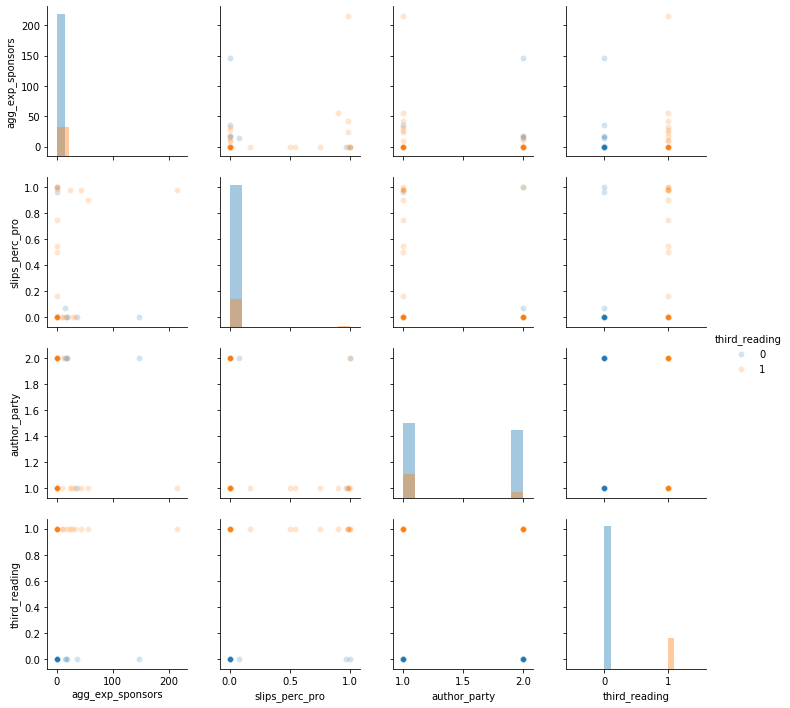

In [63]:
sns.pairplot(
    outlier_data[best_features + ['third_reading']],
    hue='third_reading',
    plot_kws={'alpha': 0.2},
    diag_kind='hist',
    diag_kws={'alpha': 0.4}
)

In [64]:
# Might need to do oversampling